## ISE364
## Brad Kelly, Cameron Shollenberger, Onur Gencer Ates, Jacob Beyloune, Thomas Day
## Professor Louis Plebani 


In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import preprocessing

In [96]:
data = pd.read_csv('data.csv', header =None)

In [97]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,A0,77516,B0,13,C0,D0,E0,F0,G0,2174,0,40,H0,SMALL
1,50,A1,83311,B0,13,C1,D1,E1,F0,G0,0,0,13,H0,SMALL
2,38,A2,215646,B1,9,C2,D2,E0,F0,G0,0,0,40,H0,SMALL
3,53,A2,234721,B2,7,C1,D2,E1,F1,G0,0,0,40,H0,SMALL
4,28,A2,338409,B0,13,C1,D3,E2,F1,G1,0,0,40,H1,SMALL


# Normalize data

Split data into categorical and numerical so that we can normalize the numerical data.  

In [98]:
df = pd.get_dummies(data, columns = [1,3,5,6,7,8,9,13], drop_first = True)

In [99]:
df.insert(11,'1_A5', 0)
df.insert(39,'6_D11', 0)
df.insert(96,'13_H4', 0)

In [100]:
X_nn = df.drop(14, axis = 1)
Y_nn = df[14]

Get dummy variables of all categorical features.  It may also be of interest to convert these to numeric, but for now I'm just going to make them binary features.

In [102]:
from sklearn.model_selection import train_test_split

In [103]:
X_train, X_test , Y_train, Y_test = train_test_split(X_nn,Y_nn, test_size = 0.3, random_state = 101)

Get base estimate if we just guess the more common size, small vs large

In [104]:
count_small = Y_test[Y_test == "SMALL"].count()
count_large = Y_test[Y_test == "LARGE"].count()
count = Y_test.count()

If we always guessed small with the test data, our accuracy would be equal to 0.745165

In [105]:
print (count_small/count)

0.7611833350394104


In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [176]:
rfc_tuned = RandomForestClassifier(n_estimators = 300,max_depth = 11, random_state = 42)
rfc_tuned.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=11, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [177]:
rfc_pred = rfc_tuned.predict(X_test)

In [178]:
print(classification_report(Y_test,rfc_pred))

              precision    recall  f1-score   support

       LARGE       0.82      0.56      0.66      2333
       SMALL       0.87      0.96      0.92      7436

    accuracy                           0.86      9769
   macro avg       0.85      0.76      0.79      9769
weighted avg       0.86      0.86      0.85      9769



In [179]:
#error rate
test_error =  ((confusion_matrix(Y_test,rfc_pred)[0][1]+confusion_matrix(Y_test,rfc_pred)[1][0])/count)
print (1 - test_error)

0.8647763332992118


In [180]:
from sklearn.metrics import roc_auc_score

y_predicted = rfc_tuned.predict_proba(X_test)[:,1]
auc = roc_auc_score(Y_test,y_predicted)

print(auc)

0.9162597557739172


# Attempt to use GridSearchCV

In [31]:
from sklearn.model_selection import GridSearchCV

In [138]:
rfc = RandomForestClassifier(random_state = 42)

In [139]:
n_estimators = [300]
max_depth = [11]
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

gridF = GridSearchCV(rfc, hyperF, cv = 2, verbose = 1, 
                      n_jobs = -1)
bestF = gridF.fit(X_train, Y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:   50.7s finished


In [140]:
bestF.get_params()

{'cv': 2,
 'error_score': 'raise-deprecating',
 'estimator__bootstrap': True,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 'warn',
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': 42,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=None, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, 

In [141]:
Y_preds = bestF.predict(X_test)

In [142]:
test_error =  ((confusion_matrix(Y_test,Y_preds)[0][1]+confusion_matrix(Y_test,Y_preds)[1][0])/count)
print (1-test_error)

0.8636503224485618


# Tuning max depth and n-estimators

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Applications/anaconda3/lib/python3.7/si

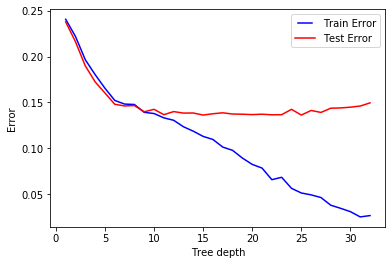

In [111]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    dtree = RandomForestClassifier(max_depth=max_depth,random_state=42)
    dtree.fit(X_train, Y_train)
    train_pred = dtree.predict(X_train)
   
    train_results.append(((confusion_matrix(Y_train,train_pred)[0][1]+confusion_matrix(Y_train,train_pred)[1][0])/Y_train.count()))
   

    y_pred = dtree.predict(X_test)
    
    test_results.append(((confusion_matrix(Y_test,y_pred)[0][1]+confusion_matrix(Y_test,y_pred)[1][0])/count))

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths, train_results, 'b', label= 'Train Error')
line2, = plt.plot(max_depths, test_results, 'r', label= 'Test Error')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Error')
plt.xlabel('Tree depth')
plt.show()

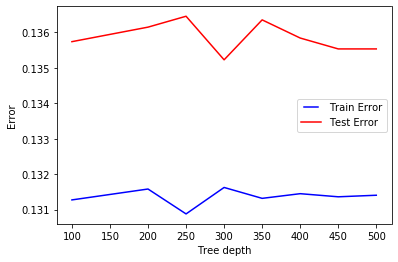

In [118]:
max_depths = [100,200,250,300,350,400,450,500]
train_results = []
test_results = []
for max_depth in max_depths:
    dtree = RandomForestClassifier(n_estimators=max_depth,max_depth = 11, random_state=42)
    dtree.fit(X_train, Y_train)
    train_pred = dtree.predict(X_train)
   
    train_results.append(((confusion_matrix(Y_train,train_pred)[0][1]+confusion_matrix(Y_train,train_pred)[1][0])/Y_train.count()))
   

    y_pred = dtree.predict(X_test)
    
    test_results.append(((confusion_matrix(Y_test,y_pred)[0][1]+confusion_matrix(Y_test,y_pred)[1][0])/count))

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(max_depths, train_results, 'b', label= 'Train Error')
line2, = plt.plot(max_depths, test_results, 'r', label= 'Test Error')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Error')
plt.xlabel('Tree depth')
plt.show()

# Futures Predictions

In [181]:
futures = pd.read_csv('futures.csv',header=None)

futures_final = pd.get_dummies(futures, columns = [1,3,5,6,7,8,9,13], drop_first = True)
futures_final.insert(8,'1_A2',0)
futures_final.insert(44,'6_D3',0)
futures_final.insert(62,'13_H1',0)
futures_final.insert(97,'13_H41',0)

futures_predictions = rfc_tuned.predict(futures_final)

futures_predictions_df = pd.DataFrame(futures_predictions)

futures_with_pred = futures.merge(futures_predictions_df,left_index = True, right_index = True)

In [182]:
futures_with_pred.head()

,0_x,1,2,3,4,5,6,7,8,9,10,11,12,13,0_y
0,38,A0,89814,B1,9,C1,D1,E1,F1,G0,0,0,50,H0,SMALL
1,28,A1,336951,B2,12,C1,D2,E1,F1,G0,0,0,40,H0,SMALL
2,44,A0,160323,B3,10,C1,D0,E1,F0,G0,7688,0,40,H0,LARGE
3,18,?,103497,B3,10,C0,?,E0,F1,G1,0,0,30,H0,SMALL
4,63,A3,104626,B5,15,C1,D5,E1,F1,G0,3103,0,32,H0,SMALL


In [184]:
futures_with_pred.to_csv('futuresFinal.csv', index = None, header = False )